In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import scipy as sp
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

import warnings
warnings.simplefilter("ignore")
plt.style.use('fivethirtyeight')

In [2]:
def filter_dunder(any_obj):
    temp_list = dir(any_obj)
    date_obj_meth_attr = []
    for i in temp_list:
        if i[0:2] != '__':
            date_obj_meth_attr.append(i)
    date_obj_meth_attr = {'meth_attr':date_obj_meth_attr}
    return pd.DataFrame(date_obj_meth_attr)

## Import Data From CSV

In [3]:
oil = pd.read_csv('oil.csv', na_values = 'n/a', parse_dates = ['date'], index_col = ['date'])
oil.columns = ['oil_price']
oil.head()

,oil_price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [4]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   oil_price  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


In [5]:
oil['oil_price'].isnull().sum()

43

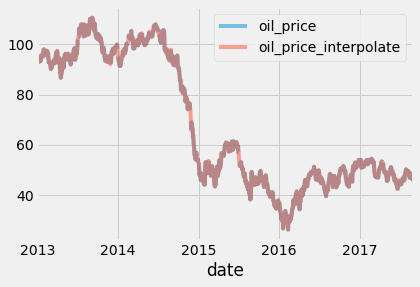

In [6]:
oil_interpolate = oil['oil_price'].interpolate().to_frame()
oil.join(oil_interpolate.add_suffix('_interpolate')).plot(alpha=.5)
plt.show()

In [7]:
df_oil = pd.concat([oil, oil_interpolate], axis= 1)

## Import Data From Excel With Loop

In [41]:
xlsx_ojb = pd.ExcelFile('listings_info.xlsx')
sheetnames = xlsx_ojb.sheet_names

listings = [] # each element of the list is a dataframe
for sheetname in sheetnames:
    df = pd.read_excel(xlsx_ojb, na_values='n/a', sheet_name = sheetname)
    df['Exchange'] = sheetname
    listings.append(df)
listings_concat = pd.concat(listings)
listings_concat.head(5)

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
0,XXII,"22nd Century Group, Inc",1.3300,1.206285e+08,NaN,Consumer Non-Durables,Farming/Seeds/Milling,amex
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1.266333e+09,1986.0,NaN,NaN,amex
2,IAF,Aberdeen Australia Equity Fund Inc,6.1500,1.398653e+08,NaN,NaN,NaN,amex
3,CH,"Aberdeen Chile Fund, Inc.",7.2201,6.756346e+07,NaN,NaN,NaN,amex
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,1.288430e+08,NaN,NaN,NaN,amex


In [42]:
listings_concat.tail(5)

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
3142,ZB^H,Zions Bancorporation,25.30,0.000000e+00,NaN,NaN,NaN,nyse
3143,ZBK,Zions Bancorporation,28.86,0.000000e+00,NaN,Finance,Major Banks,nyse
3144,ZOES,"Zoe&#39;s Kitchen, Inc.",17.07,3.325561e+08,2014.0,Consumer Services,Restaurants,nyse
3145,ZTS,Zoetis Inc.,53.10,2.610544e+10,2013.0,Health Care,Major Pharmaceuticals,nyse
3146,ZTO,ZTO Express (Cayman) Inc.,12.63,9.237663e+09,2016.0,Transportation,Trucking Freight/Courier Services,nyse


## Pick The Largest Company In Finance Sector

In [43]:
listings_concat = listings_concat.set_index('Stock Symbol')
listings_concat.head(5)

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
XXII,"22nd Century Group, Inc",1.3300,1.206285e+08,NaN,Consumer Non-Durables,Farming/Seeds/Milling,amex
FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1.266333e+09,1986.0,NaN,NaN,amex
IAF,Aberdeen Australia Equity Fund Inc,6.1500,1.398653e+08,NaN,NaN,NaN,amex
CH,"Aberdeen Chile Fund, Inc.",7.2201,6.756346e+07,NaN,NaN,NaN,amex
ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,1.288430e+08,NaN,NaN,NaN,amex


In [69]:
n_largest = 10
tickers_fin_larg3 = listings_concat.loc[listings_concat['Sector']=='Finance','Market Capitalization'].nlargest(n_largest).index

In [70]:
start = dt.date(2010, 1, 1)
stocks_fin_larg3 = pdr.data.DataReader(tickers_fin_larg3, 'yahoo', start)

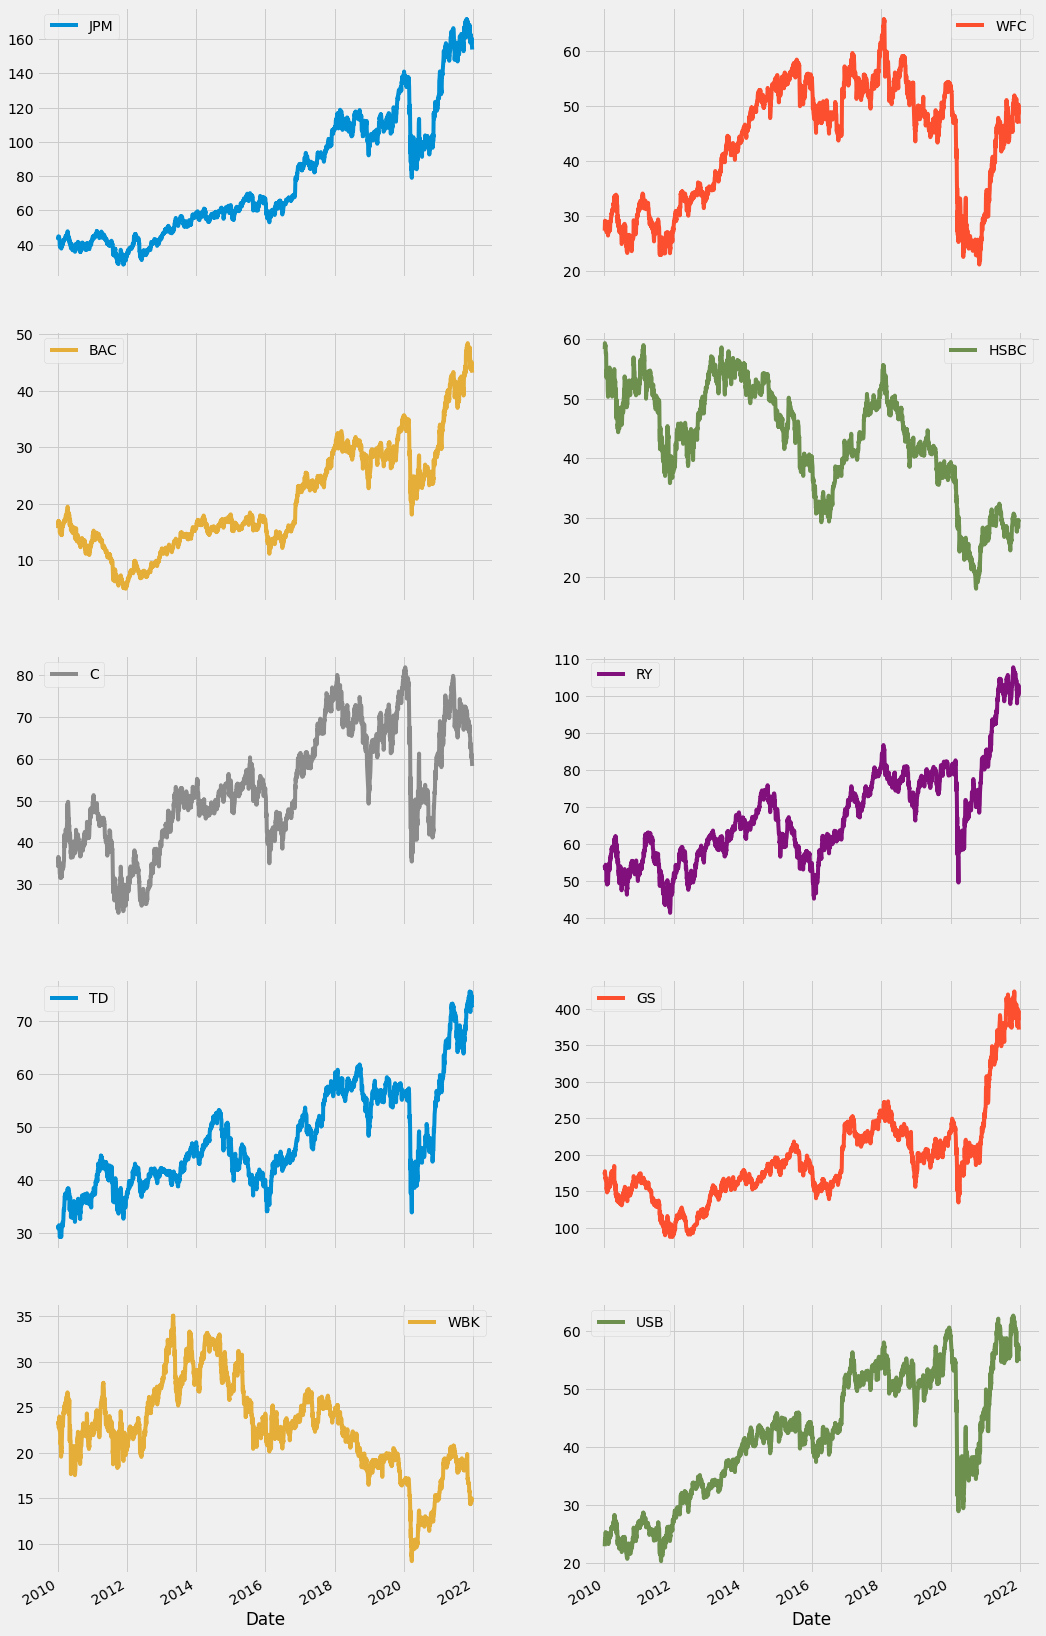

In [74]:
stocks_fin_larg3['Close'].plot(subplots = True, layout = (5, 2), figsize=(16, 32)); plt.show()

## Pick The Largest Major Pharmaceuticals In Health Care Sector

In [79]:
listings_health = listings_concat[listings_concat['Sector']=='Health Care']
hc_type = listings_health['Industry'].unique() 
hc_type

array(['Major Pharmaceuticals', 'Hospital/Nursing Management',
       'Industrial Specialties', 'Medical Specialities',
       'Biotechnology: Biological Products (No Diagnostic Substances)',
       'Medical/Dental Instruments',
       'Biotechnology: Electromedical & Electrotherapeutic Apparatus',
       'Biotechnology: Commercial Physical & Biological Resarch',
       'Biotechnology: In Vitro & In Vivo Diagnostic Substances',
       'Medical/Nursing Services', 'Medical Electronics',
       'Precision Instruments', 'Other Pharmaceuticals',
       'Ophthalmic Goods'], dtype=object)

In [98]:
tickers_hc_large = listings_health[listings_health['Industry']=='Major Pharmaceuticals']['Market Capitalization'].nlargest(n_largest).index

In [99]:
stocks_hc_large = pdr.data.DataReader(tickers_hc_large, 'yahoo', start)

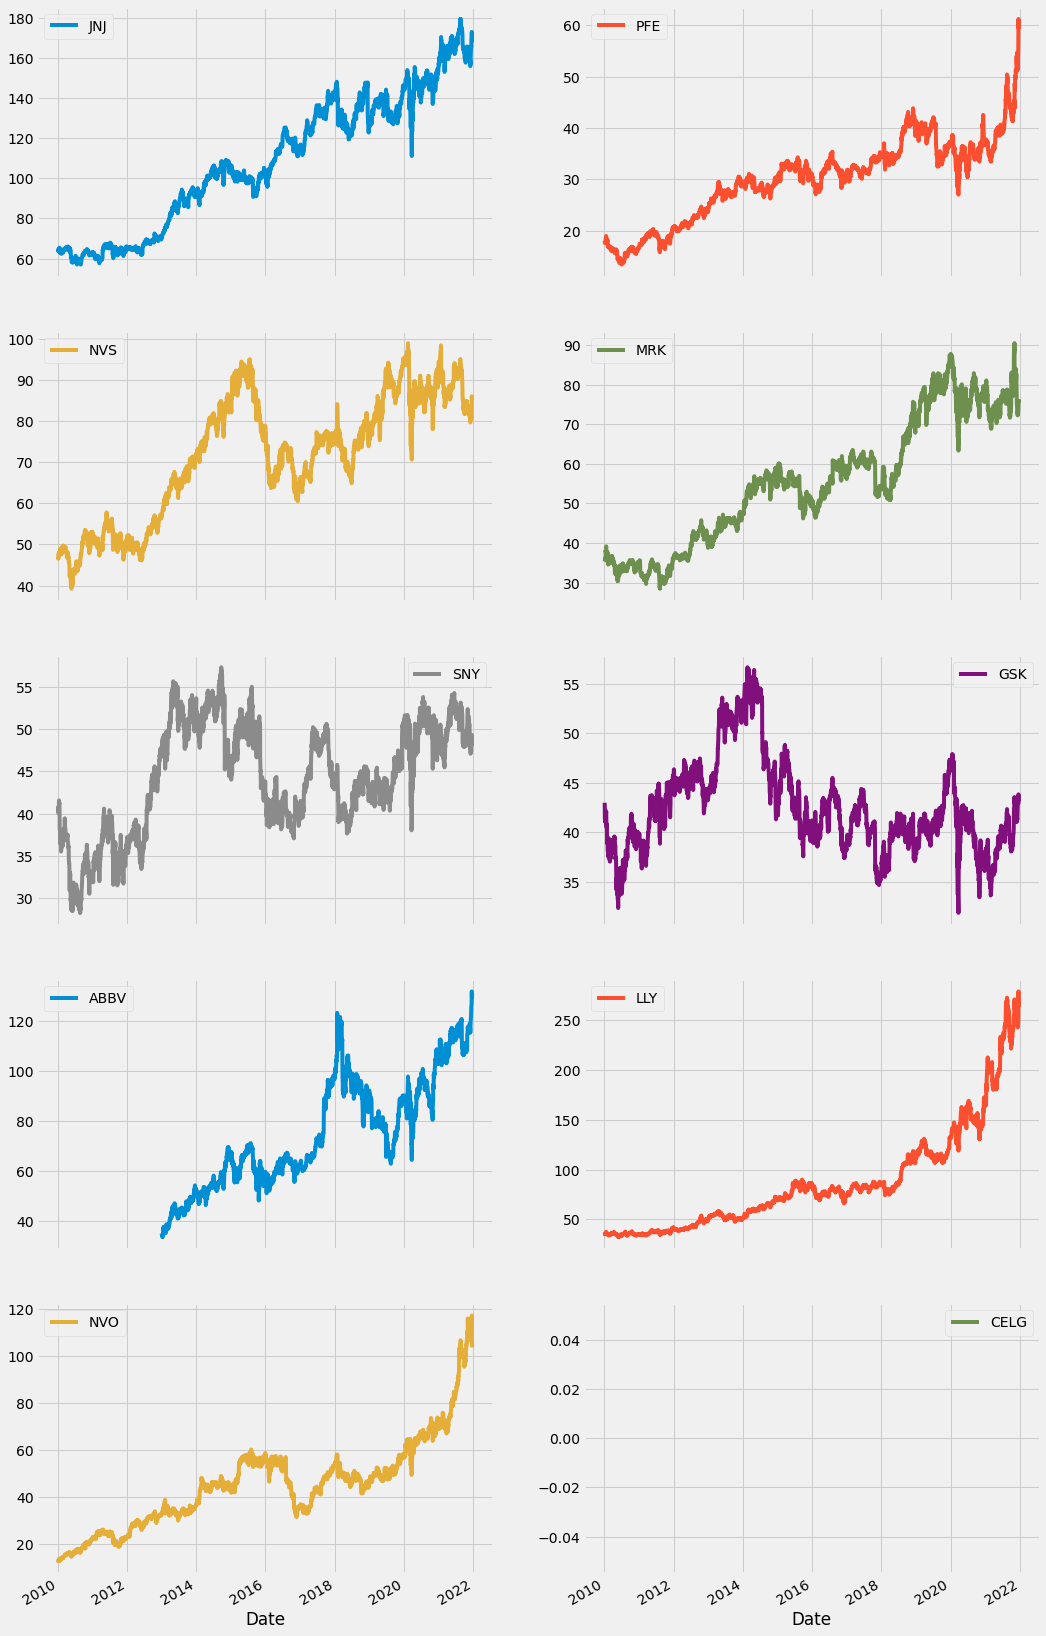

In [111]:
stocks_hc_large['Close'].plot(subplots = True, layout = (5, 2), figsize=(16, 32)); plt.show()

## Multiple Criteria in ```.loc```

In [119]:
listings_concat.loc[(listings_concat['IPO Year'] > 2008) & (listings_concat['Industry'] == 'Precious Metals')]

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
AAU,"Almaden Minerals, Ltd.",1.72,1.548917e+08,2015.0,Basic Industries,Precious Metals,amex
USAS,Americas Silver Corporation,3.05,1.206948e+08,2017.0,Basic Industries,Precious Metals,amex
PZG,Paramount Gold Nevada Corp.,1.80,3.200392e+07,2015.0,Basic Industries,Precious Metals,amex
TGD,Timmons Gold Corp,0.43,1.529203e+08,2011.0,Basic Industries,Precious Metals,amex
WRN,Western Copper and Gold Corporation,1.28,1.217160e+08,2011.0,Basic Industries,Precious Metals,amex
AGI,Alamos Gold Inc.,8.20,2.450240e+09,2015.0,Basic Industries,Precious Metals,nyse
OR,Osisko Gold Royalties Ltd,11.27,1.201307e+09,2016.0,Basic Industries,Precious Metals,nyse


In [ ]:
time_stamp = pd.Timestamp(dt.datetime(2021,12,25))

In [ ]:
filter_dunder(time_stamp)

In [ ]:
print(time_stamp.year)
print(time_stamp.month)
print(time_stamp.day)
print(time_stamp.day_name())

In [ ]:
print(time_stamp)

In [ ]:
period = pd.Period('2021-8'); period

In [ ]:
period_2 = pd.Period('2021-8-28', 'D'); period_2

In [ ]:
print(period + 2)

In [ ]:
print(period_2 - 10)

## Sequence of Time

Each object in the ```date_range``` is a ```Timestamp``` object.

In [ ]:
index = pd.date_range(start = '2010-12', end = '2021-12', freq = 'M')
index

In [ ]:
index.to_period()

In [ ]:
index_2 = pd.date_range(start= '2021-12-1', periods = 10)
for day in index_2:
    print(str(day.day) + ':' + day.day_name())

In [ ]:
index_2

## Create a Time Series

In [ ]:
time_series = pd.DataFrame({'Time':index})

In [ ]:
time_series.info()

In [ ]:
data = np.random.randn(len(index), 2)

In [ ]:
time_series = pd.DataFrame(data = data, index = index, columns =['Series_1', 'Series_2'])

Colormap is <a href='https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html'> here </a>

In [ ]:
time_series.plot(colormap = 'Paired', figsize=(16, 8), subplots=True); plt.show()

In [ ]:
tesla_stockp = pdr.data.DataReader(name = 'TSLA', data_source = 'yahoo', start = '2018-1-1', end = '2021-12-1')

In [ ]:
tesla_stockp.head(10)

In [ ]:
tesla_stockp.loc['2019-11-15':'2021-11-15', ['Close']].plot(figsize=(16, 8), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

Upsampling to including non-trade days, such as weekends.

In [ ]:
tesla_stockp.asfreq('D').head(10)

In [ ]:
tesla_stockp.asfreq('D').loc['2019-11-15':'2021-11-15', ['Close']].plot(figsize=(16, 8), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

## Compare Each Years Data

In [ ]:
tesla_prices = pd.DataFrame()
for year in ['2018', '2019', '2020', '2021']:
    price_per_year = tesla_stockp.loc[year, ['Close']].reset_index(drop=True)
    price_per_year.rename(columns={'Close':year+' close'}, inplace=True)
    tesla_prices = pd.concat([tesla_prices, price_per_year], axis=1)
    
tesla_prices.head()

In [ ]:
tesla_prices.plot(figsize=(16, 8), title ='Tesla Stock Price Comparison'); plt.show()

## Resampling

In [ ]:
tesla_stockp['Close'].asfreq('W-Wed').plot(figsize = (16, 8)); plt.show()

In [ ]:
tesla_stockp['Close'].asfreq('M').plot(figsize = (16, 8)); plt.show()

## Lagged Variable

In [ ]:
tesla_stockp['Lag_1'] = tesla_stockp['Close'].shift()
tesla_stockp['Daily Change'] = tesla_stockp['Close'].div(tesla_stockp['Lag_1'])

In [ ]:
tesla_stockp.head()

In [ ]:
tesla_stockp['Daily Change'].plot(figsize = (16, 8)); plt.show()

## Growth Rate

In [ ]:
tesla_stockp['change_pct'] = tesla_stockp['Close'].pct_change()

In [ ]:
tesla_stockp['change_pct'].plot(figsize = (16, 8)); plt.show()

In [ ]:
tesla_stockp['change_pct_daily'] = tesla_stockp['Close'].pct_change()
tesla_stockp['change_pct_monthly'] = tesla_stockp['Close'].pct_change(periods=30)
tesla_stockp['change_pct_yearly'] = tesla_stockp['Close'].pct_change(periods=360)
tesla_stockp[['change_pct_daily', 'change_pct_monthly', 'change_pct_yearly']]\
.plot(subplots=True, figsize = (16, 8)); plt.show()

In [ ]:
# SP500, Gold, Crude oil, Gold, Bitcoin, Nikkei 225
assets_tickers =  ['^GSPC', 'GC=F', 'CL=F', 'BTC-USD', '^N225']
legends = ['SP500', 'Gold', 'Crude oil', 'Gold', 'Bitcoin', 'Nikkei 225']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date)

In [ ]:
normalized_prices = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

In [ ]:
price_plot = normalized_prices.plot(figsize = (16, 7))
price_plot.legend(legends)
plt.show()

## Correlation

In [ ]:
assets_close = assets_price['Close']
assets_close.columns = ['SP500', 'Crude oil', 'Gold', 'Bitcoin', 'Nikkei 225']

In [ ]:
sns.jointplot(x='Nikkei 225', y='SP500', data=assets_close.pct_change()); plt.show()

In [ ]:
assets_corr = assets_close.pct_change().corr()
sns.heatmap(assets_corr, annot=True, cmap = sns.cm.rocket_r,annot_kws={"size": 20}); plt.show()

Furthermore, ```clustermap``` can organize similar data by similarity, which brings more insight into the data set.

In [ ]:
sns.clustermap(assets_corr, cmap = sns.cm.rocket_r); plt.show()

## Normalization

In [ ]:
assets_tickers =  ['^GSPC', 'GOOG', 'FB', 'AMZN', 'AAPL', 'NFLX']
legends = ['SP500', 'Google', 'Meta', 'Amazon', 'Apple', 'Netflix']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date).dropna()

price_plot = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

Make them start from $0$.

In [ ]:
normalized = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

price_plot = normalized[assets_tickers].sub(normalized['^GSPC'], axis = 0).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

## Changing Data Frequency

In [ ]:
start = '2021-1-15'
end = '2021-12-20'
dates = pd.date_range(start = start, end = end, freq='M')
dates

In [ ]:
monthly = pd.Series(data = np.arange(len(dates)), index = dates); monthly

In [ ]:
weekly_dates = pd.date_range(start = start, end = end, freq='W'); weekly_dates

Conform the data with new index. ```bfill``` and ```ffill``` mean fill backward and forward.

In [ ]:
monthly.reindex(weekly_dates).head(10)

In [ ]:
monthly.reindex(weekly_dates, method = 'bfill').head(10)

In [ ]:
monthly.reindex(weekly_dates, method = 'ffill').head(10)

In [ ]:
df_unempl = pdr.data.DataReader(name='UNRATE', data_source='fred', start = '2000-1-1', end = dt.date.today())
df_unempl.columns = ['Unemployment_Rate']
df_unempl.plot(figsize=(16, 6))
plt.show()

In [ ]:
df_unempl.head()

Change the frequency to weekly data, the missing values will be filled by existing values.

In [ ]:
df_unempl_bfill = df_unempl.asfreq('W', method='bfill')
df_unempl_ffill = df_unempl.asfreq('W', method='ffill')
df_unempl_concat = pd.concat([df_unempl_bfill, df_unempl_ffill], axis=1)
df_unempl_concat.columns =['unemp_rate_bfilled_weekly', 'unemp_rate_ffilled_weekly']

In [ ]:
df_unempl_concat.plot(figsize=(16, 6)); plt.show()

## Interpolation

In [ ]:
lab_part = pdr.data.DataReader(name='CIVPART', data_source='fred', start = '2010-1-1', end = dt.date.today())
lab_part.columns = ['Labor_Participation_Rate']
lab_part.plot(figsize=(16, 6))
plt.show()

In [ ]:
daily_dates = pd.date_range(start=lab_part.index.min(), end=lab_part.index.max(), freq='D')

In [ ]:
lab_part_daily = lab_part.reindex(daily_dates)
lab_part_daily['forward_fill'] = lab_part_daily['Labor_Participation_Rate'].ffill()
lab_part_daily['interpolation'] = lab_part_daily['Labor_Participation_Rate'].interpolate() # this is exactly the plot above

In [ ]:
lab_part_daily.plot(figsize=(16, 6)); plt.show()

In [ ]:
df = pdr.data.DataReader(name=['DFII10','GOLDAMGBD228NLBM'], data_source='fred', start = '2010-1-1', end = dt.date.today())

In [ ]:
df.columns = ['10y_TB_yield','Gold_Fix_London_10AM']

In [ ]:
ax = df.plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
ax = df.resample('M').mean().plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
ax = df.resample('A').mean().plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
df.resample('M').first().head()

In [ ]:
df.resample('M').last().head()

## Conform the Frequency Among Time Series

In [ ]:
data_list = ['GDPC1', 'SP500', 'U2RATE']
df = pdr.data.DataReader(name=data_list, data_source='fred', start = '2010-1-1', end = '2020-1-1')

In [ ]:
df.columns = ['realGDP', 'SP500', 'unempRate']

In [ ]:
sp500_chrate_quarterly = df['SP500'].resample('QS').first().pct_change()
unempRate_quarterly = df['unempRate'].resample('QS').first().pct_change()
gdp_chrate = df['realGDP'].dropna().pct_change()

In [ ]:
df_quarterly = pd.concat([gdp_chrate, sp500_chrate_quarterly, unempRate_quarterly], axis=1)

In [ ]:
df_quarterly.plot(figsize=(16, 7)); plt.show()

## Apply Multiple Function

In [ ]:
nk225 = pdr.data.DataReader(name='NIKKEI225', data_source='fred', start = '2000-1-1', end = dt.datetime.today())

In [ ]:
nk225_daily_return = nk225.pct_change()

In [ ]:
nk225_stats = nk225_daily_return.resample('W').agg(['mean', 'median', 'std'])

In [ ]:
nk225_stats.plot(figsize=(16, 6), alpha=.7); plt.show()

## Rolling Window

In [ ]:
start_date = '2010-1-1'
end_date = '2021-12-1'
usdjpy = pdr.data.DataReader(name = 'DEXJPUS', data_source = 'fred', start = start_date, end = end_date).dropna()

In [ ]:
usdjpy['30D'] = usdjpy['DEXJPUS'].rolling(window='30D').mean()
usdjpy['60D'] = usdjpy['DEXJPUS'].rolling(window='60D').mean()
usdjpy['120D'] = usdjpy['DEXJPUS'].rolling(window='120D').mean()

In [ ]:
usdjpy.plot(figsize=(16, 10), grid=True, title = 'USDJPY and Rolling Means'); plt.show()

In [ ]:
usdchf = pdr.data.DataReader(name = 'DEXSZUS', data_source = 'fred', start = start_date, end = end_date).dropna()
rolling_stats = usdchf['DEXSZUS'].rolling(window=30).agg(['mean', 'std']).dropna()
usdchf = usdchf.join(rolling_stats)
usdchf.plot(subplots=True, figsize=(16, 12), grid=True); plt.show()

## Rolling Window With Upper And Lower Bound

In [ ]:
usdjpy['mstd'] = usdjpy['DEXJPUS'].rolling(window=120).std()
usdjpy['ma'] = usdjpy['DEXJPUS'].rolling(window=120).mean()
usdjpy['upper'] = usdjpy['ma'] + usdjpy['mstd']*2
usdjpy['lower'] = usdjpy['ma'] - usdjpy['mstd']*2

In [ ]:
usdjpy.iloc[:, 5:8].plot(figsize=(16, 6), title='120D rolling Window Bounds of USDJPY'); plt.show()

## Rolling Quantile

In [ ]:
dxy = pdr.data.DataReader(name = 'DTWEXBGS', data_source = 'fred', start = start_date, end = end_date).dropna()
dxy.columns = ['DXY']
dxy_rolling = dxy['DXY'].rolling(window=30)

dxy['q10'] = dxy_rolling.quantile(.1)
dxy['q50'] = dxy_rolling.quantile(.5)
dxy['q90'] = dxy_rolling.quantile(.9)

In [ ]:
dxy.plot(grid=True, figsize=(16, 7)); plt.show()

## Cumulative Sum

The cumulative summation is the opposite operation of first order difference, but don't do this, they will produce different results.

In [ ]:
sp500 = pdr.data.DataReader(name='SP500', data_source='fred', start = '2010-1-1', end = dt.datetime.today())

In [ ]:
sp500_diff = sp500.diff().dropna()

In [ ]:
first_day = sp500.first('D')
cumulative = first_day.append(sp500_diff).cumsum()

In [ ]:
sp500.join(cumulative.add_suffix('_recovered')).plot(figsize=(16, 8), grid=True);plt.show()

## Cumulative Return

In [ ]:
init_investment = 50000

Retrieve Lululemon's closing price.

In [ ]:
lulu = pdr.data.DataReader(name='LULU', data_source='yahoo', start = '2010-1-1', end = dt.datetime.today())['Close'].to_frame()

In [ ]:
lulu_cum_ret = lulu.pct_change().add(1).cumprod()

In [ ]:
(init_investment*lulu_cum_ret).plot(figsize=(16, 8), grid=True, title='Lululemon Investment');plt.show()

In [ ]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [ ]:
# Lululemon, Nike, Adidas, Under Armour, Anta
stocks_list = ['LULU', 'NKE', 'ADS.F', 'UA', 'AS7.F']
stocks = pdr.data.DataReader(name=stocks_list, data_source='yahoo', start = '2017-1-1', end = dt.datetime.today())['Close']
stocks.columns = ['Lululemon', 'Nike', 'Adidas', 'Under Armour', 'Anta']

In [ ]:
stocks.pct_change().rolling(window='360D')\
.apply(multi_period_return).mul(100).plot(figsize=(16, 8), grid=True, title='Sports Brands Rolling Return')
plt.show()

## Simulating Stocks Growth

In [ ]:
rand_walk = pd.Series(sp.stats.norm.rvs(loc = .0005, scale = .012, size = 3000))
(1 + rand_walk).cumprod().plot(figsize=(16, 8), grid=True);plt.show()

In [ ]:
lulu = pdr.data.DataReader(name='LULU', data_source='yahoo', start = '2010-1-1', end = dt.datetime.today())['Close'].to_frame()
daily_lulu = lulu.pct_change().dropna()
lulu_simu = pd.Series(np.random.choice(daily_lulu.values.flatten(), len(daily_lulu)))
sns.displot(lulu_simu); plt.show()

In [ ]:
first = lulu['Close'].first('D')
ts_holder = first.append(1 + lulu_simu) #ts_holder time series holder, temp variable holder
ts_holder = ts_holder.cumprod()
ts_holder.index = lulu.index
lulu['lulu_sim_price'] = ts_holder
lulu.plot(figsize=(16, 8), grid=True);plt.show()

## Listings Example

In [ ]:
nasdaq = pd.read_excel('listings_info.xlsx', sheet_name='nasdaq', na_values=True)

In [ ]:
nasdaq.head()

In [ ]:
nasdaq.set_index('Stock Symbol', inplace=True)

In [ ]:
nasdaq.dropna(subset=['Sector'], inplace=True) # remove companies without sector info

In [ ]:
nasdaq['Market Capitalization']/=1e6

In [ ]:
nasdaq.info()

In [ ]:
top_comp = nasdaq.groupby(['Sector'])['Market Capitalization'].nlargest(1).sort_values(ascending=False)
top_comp

In [ ]:
tickers = top_comp.index.get_level_values(1) # use 0, 1...any integer to refer to the level of indices
tickers = tickers.tolist()
tickers

In [ ]:
columns = ['Company Name', 'Market Capitalization', 'Last Sale']
comp_info = nasdaq.loc[tickers, columns].sort_values(by='Market Capitalization', ascending=False)
comp_info['no_share'] = comp_info['Market Capitalization']/comp_info['Last Sale']
comp_info.dtypes

In [ ]:
comp_info

In [ ]:
stocks = pdr.data.DataReader(name=tickers, 
                             data_source='yahoo', 
                             start = '2000-1-1', 
                             end = dt.datetime.today())['Close']

In [ ]:
stocks.head()

In [ ]:
returns = (stocks.iloc[-1]/stocks.loc['2018-1-2']-1)*100
returns.plot(kind='barh', figsize = (12, 6), grid=True)
plt.show()

## Group By Month

In [ ]:
stock_index = pdr.data.DataReader(name=['SP500', 'NIKKEI225', 'NASDAQCOM'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())

In [ ]:
stock_index.groupby(stock_index.index.month).mean().plot(subplots=True, figsize=(15, 10)); plt.show()

In [ ]:
stock_index.groupby(stock_index.index.day).mean().plot(subplots=True, figsize=(15, 10)); plt.show()

## Boxplot

In [ ]:
stock_index[['SP500']].diff().boxplot();plt.show()

In [ ]:
stock_index[['SP500']].plot(kind='hist', bins=100);plt.show()

In [ ]:
stock_index[['SP500']].plot(kind='density');plt.show()

## Plotting Autocorrelation

In [ ]:
fig = tsaplots.plot_acf(stock_index['SP500'].dropna())

In [ ]:
fig = tsaplots.plot_pacf(stock_index['SP500'].dropna())

## Decomposition

In [ ]:
tot_constr_China = pdr.data.DataReader(name=['CHNPRCNTO01MLQ'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())
tot_constr_China.columns = ['constru_data']

In [ ]:
decomp = sm.tsa.seasonal_decompose(tot_constr_China['constru_data'])

In [ ]:
plt.rcParams['figure.figsize'] = 16, 10
fig = decomp.plot()

## Area Plot

In [ ]:
df = pdr.data.DataReader(name=['PCE','W068RCQ027SBEA','BOPGSTB'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())
df.columns = ['PCE', 'Gov_Exp', 'Trade_Ba']
df['Trade_Ba'] = df['Trade_Ba']/1000 # convert to billion unit
df['Gov_Exp'] = df['Gov_Exp'].interpolate()

In [ ]:
df.plot.area(stacked=False); plt.show()

## Adding Summary Statistics

In [ ]:
ax = df.plot()
df_summary = df.describe() 

ax.table(cellText=np.round(df_summary.values, 2),
         colWidths = [0.18]*len(df_summary.columns),
         rowLabels=df_summary.index,
         colLabels=df_summary.columns,
         loc='top')
ax.legend(loc='best', bbox_to_anchor=(.5, .95), ncol=3, fontsize=20)
plt.show()